<a href="https://colab.research.google.com/github/insafhamdi/Car-Insurance/blob/main/Car_Insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import required modules
import pandas as pd
import numpy as np
from statsmodels.formula.api import logit

# Read in dataset
cars = pd.read_csv("/content/car_insurance.csv")

# Check for missing values
cars.info()

# Fill missing values with the mean
cars["credit_score"].fillna(cars["credit_score"].mean(), inplace=True)
cars["annual_mileage"].fillna(cars["annual_mileage"].mean(), inplace=True)

# Empty list to store model results
models = []

# Feature columns
features = cars.drop(columns=["id", "outcome"]).columns

# Loop through features
for col in features:
    # Create a model
    model = logit(f"outcome ~ {col}", data=cars).fit()
    # Add each model to the models list
    models.append(model)

# Empty list to store accuracies
accuracies = []

# Loop through models
for feature in range(0, len(models)):
    # Compute the confusion matrix
    conf_matrix = models[feature].pred_table()
    # True negatives
    tn = conf_matrix[0,0]
    # True positives
    tp = conf_matrix[1,1]
    # False negatives
    fn = conf_matrix[1,0]
    # False positives
    fp = conf_matrix[0,1]
    # Compute accuracy
    acc = (tn + tp) / (tn + fn + fp + tp)
    accuracies.append(acc)

# Find the feature with the largest accuracy
best_feature = features[accuracies.index(max(accuracies))]

# Create best_feature_df
best_feature_df = pd.DataFrame({"best_feature": best_feature,
                                "best_accuracy": max(accuracies)},
                                index=[0])
best_feature_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  int64  
 2   gender               10000 non-null  int64  
 3   driving_experience   10000 non-null  object 
 4   education            10000 non-null  object 
 5   income               10000 non-null  object 
 6   credit_score         9018 non-null   float64
 7   vehicle_ownership    10000 non-null  float64
 8   vehicle_year         10000 non-null  object 
 9   married              10000 non-null  float64
 10  children             10000 non-null  float64
 11  postal_code          10000 non-null  int64  
 12  annual_mileage       9043 non-null   float64
 13  vehicle_type         10000 non-null  object 
 14  speeding_violations  10000 non-null  int64  
 15  duis                 10000 non-null  

,best_feature,best_accuracy
0,driving_experience,0.7771


**Interpretation**

La description du DataFrame indique que vous travaillez avec 10 000 entrées et 18 colonnes, incluant des données numériques et catégorielles. Certaines colonnes, telles que credit_score et annual_mileage, ont des valeurs manquantes qu'il faut imputer avant l'analyse.

Vous avez ajusté des modèles logistiques en utilisant chaque variable comme prédicteur pour la variable réponse outcome. La meilleure performance a été obtenue avec la variable driving_experience, qui a montré la plus grande précision (0.7771) dans la prédiction de l'outcome. Cela suggère que l'expérience de conduite est un facteur déterminant important pour prédire les résultats dans vos données.







## 1. Préparation de la base


In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer



# Imputation des valeurs manquantes
imputer = SimpleImputer(strategy='mean')
cars['credit_score'] = imputer.fit_transform(cars[['credit_score']])
cars['annual_mileage'] = imputer.fit_transform(cars[['annual_mileage']])

# Encodage des variables catégorielles
label_encoder = LabelEncoder()
categorical_vars = ['gender', 'driving_experience', 'education', 'income', 'vehicle_ownership', 'vehicle_year', 'married', 'vehicle_type', 'postal_code']
for col in categorical_vars:
    cars[col] = label_encoder.fit_transform(cars[col])

# Affichage des premières lignes pour vérifier
print(cars.head())



       id  age  gender  driving_experience  education  income  credit_score  \
0  569520    3       0                   0          0       2      0.629027   
1  750365    0       1                   0          1       1      0.357757   
2  199901    0       0                   0          0       3      0.493146   
3  478866    0       1                   0          2       3      0.206013   
4  731664    1       1                   1          1       3      0.388366   

   vehicle_ownership  vehicle_year  married  children  postal_code  \
0                  1             0        0       1.0            0   
1                  0             1        0       0.0            0   
2                  1             1        0       0.0            0   
3                  1             1        0       1.0            2   
4                  1             1        0       0.0            2   

   annual_mileage  vehicle_type  speeding_violations  duis  past_accidents  \
0         12000.0         

**Interpretation**

Colonnes Codées: Des variables comme age, gender, driving_experience, education, et d'autres sont codées numériquement, probablement pour préparation à l'analyse statistique.
Données Normalisées: credit_score est présenté sous une forme normalisée entre 0 et 1.
Variables Catégorielles: Des attributs comme vehicle_ownership, vehicle_year, married, et children sont codifiés numériquement, indiquant des catégories fixes.
Variables Comportementales: speeding_violations, duis, past_accidents indiquent le comportement de conduite.
Résultat: outcome est une variable binaire utilisée comme variable cible pour prédire un événement (par exemple, une réclamation d'assurance).
Ces données sont prêtes pour des analyses ou modélisations pour prédire les résultats basés sur les caractéristiques des conducteurs et leurs comportements.

## 2. Equilibrage des données

In [6]:
from imblearn.over_sampling import SMOTE

# Vérifier l'équilibre des classes
balance = cars['outcome'].value_counts(normalize=True)
print(balance)

# Appliquer SMOTE si déséquilibré
if balance.min() < 0.4:  # Utiliser un seuil de 0.4 comme exemple
    smote = SMOTE(random_state=42)
    X = cars.drop('outcome', axis=1)
    y = cars['outcome']
    X_sm, y_sm = smote.fit_resample(X, y)
    data_smote = pd.concat([X_sm, y_sm], axis=1)
else:
    data_smote = cars

# Affichage des nouvelles proportions
print(data_smote['outcome'].value_counts(normalize=True))



outcome
0.0    0.6867
1.0    0.3133
Name: proportion, dtype: float64
outcome
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


**Interpretation**


Les données montrent deux distributions différentes pour la variable outcome: dans la première, 68.67% des cas sont classés comme 0 et 31.33% comme 1, indiquant un déséquilibre. Dans la seconde distribution, les proportions sont équilibrées avec 50% des cas pour chaque classe (0 et 1), typiquement après l'application d'une technique de rééquilibrage comme SMOTE.

# Statistiques descriptives

                  id           age        gender  driving_experience  \
count   10000.000000  10000.000000  10000.000000        10000.000000   
mean   500521.906800      1.489500      0.499000            1.069300   
std    290030.768758      1.025278      0.500024            0.990452   
min       101.000000      0.000000      0.000000            0.000000   
25%    249638.500000      1.000000      0.000000            0.000000   
50%    501777.000000      1.000000      0.000000            1.000000   
75%    753974.500000      2.000000      1.000000            2.000000   
max    999976.000000      3.000000      1.000000            3.000000   

         education        income  credit_score  vehicle_ownership  \
count  10000.00000  10000.000000  10000.000000       10000.000000   
mean       0.97710      1.562200      0.515813           0.697000   
std        0.89892      1.008084      0.130752           0.459578   
min        0.00000      0.000000      0.053358           0.000000   
25%   

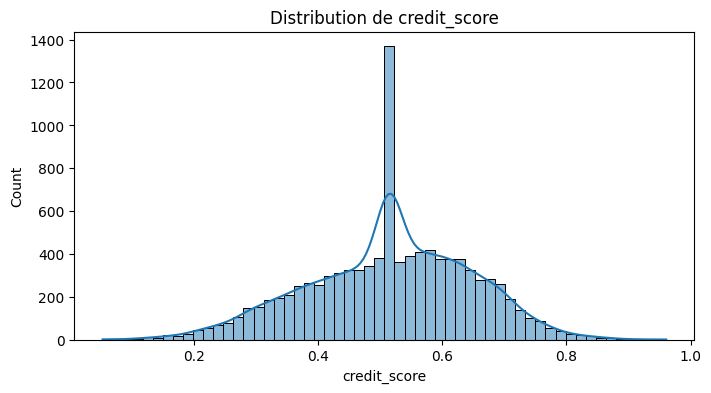

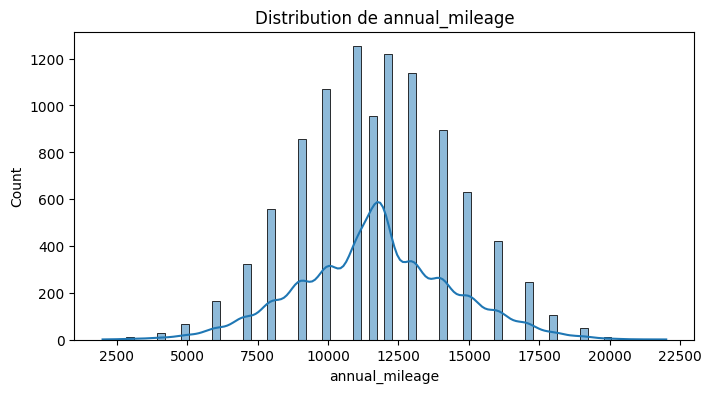

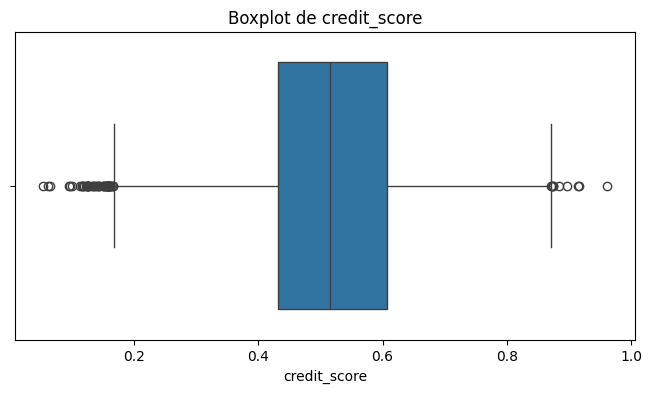

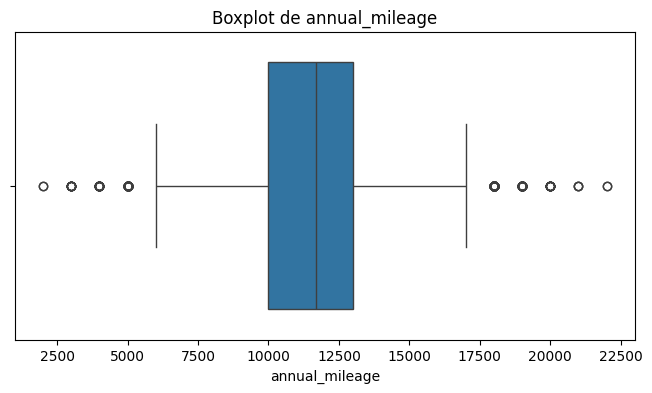

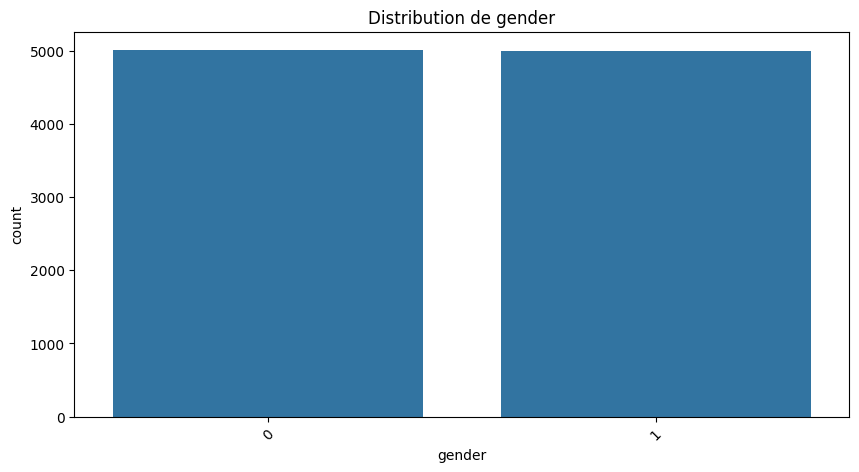

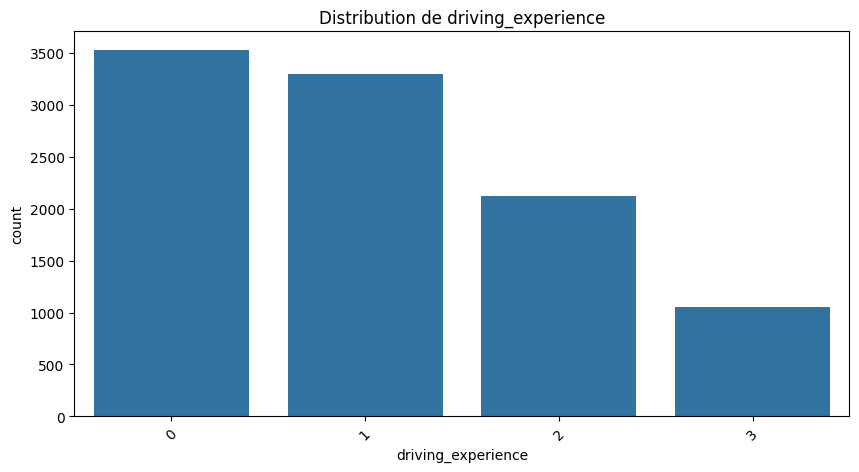

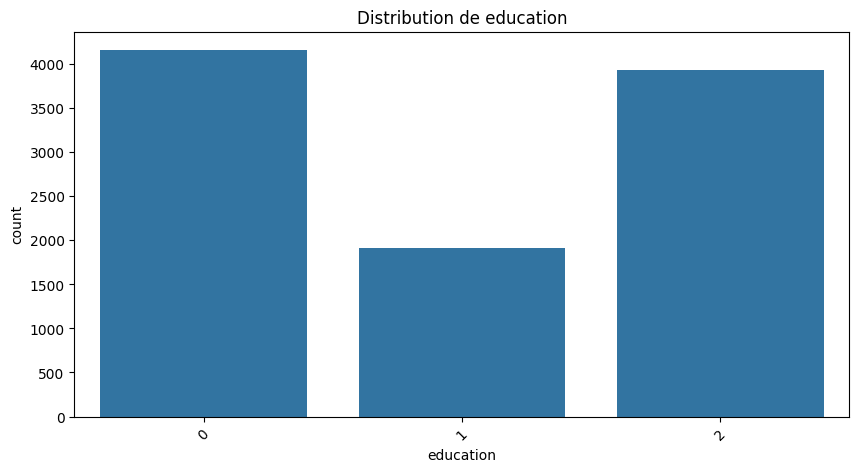

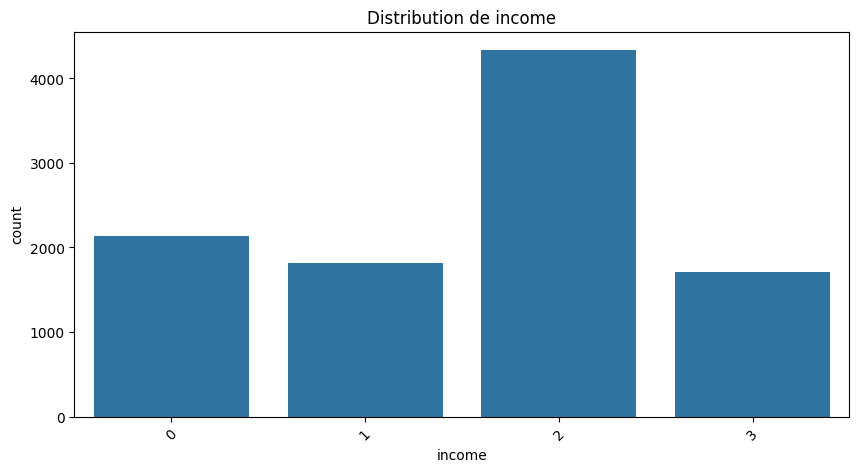

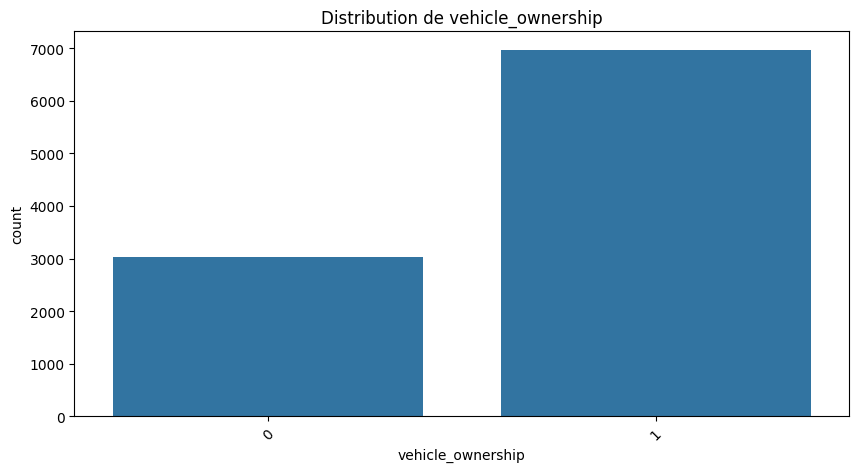

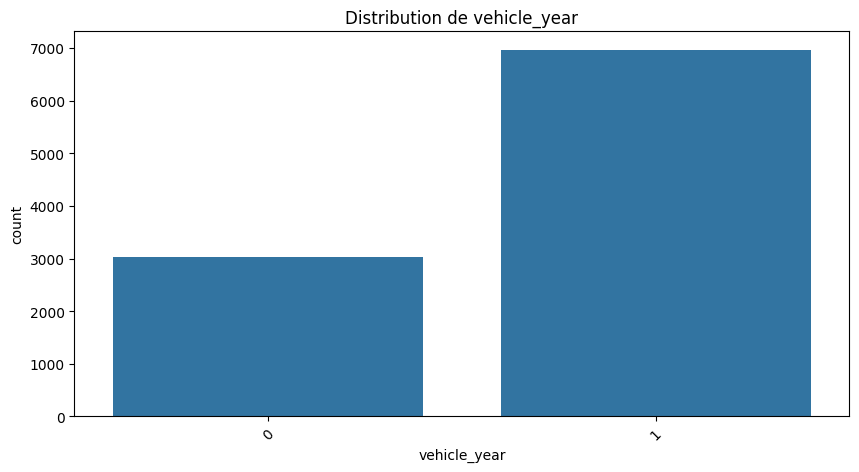

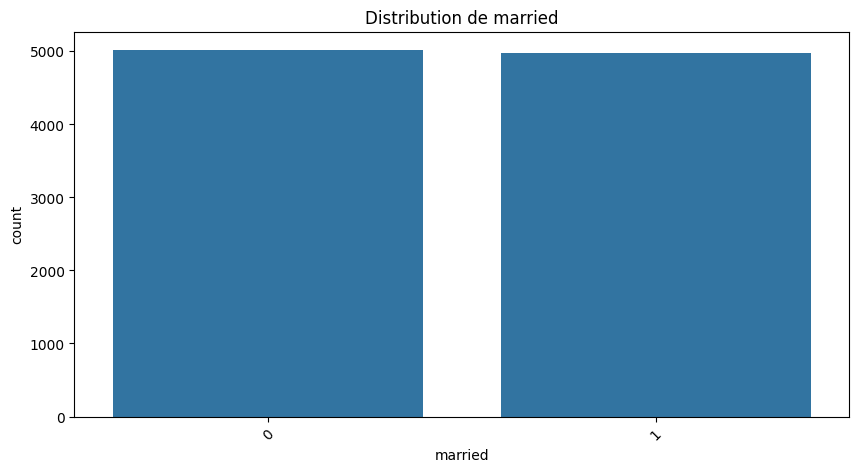

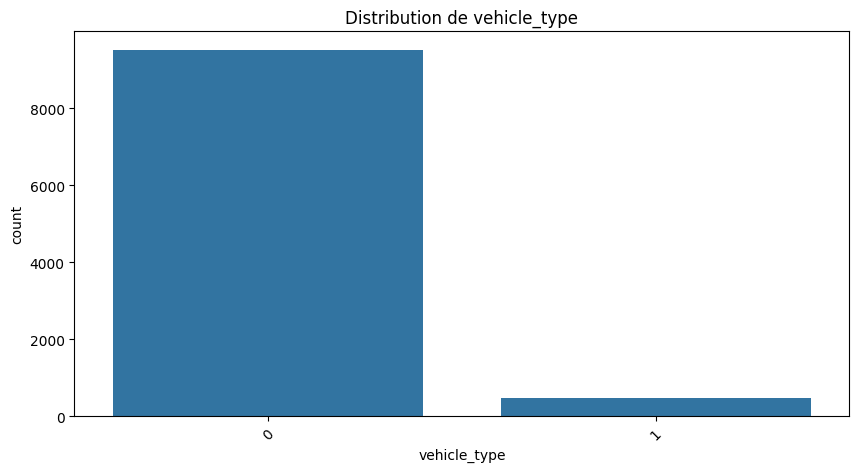

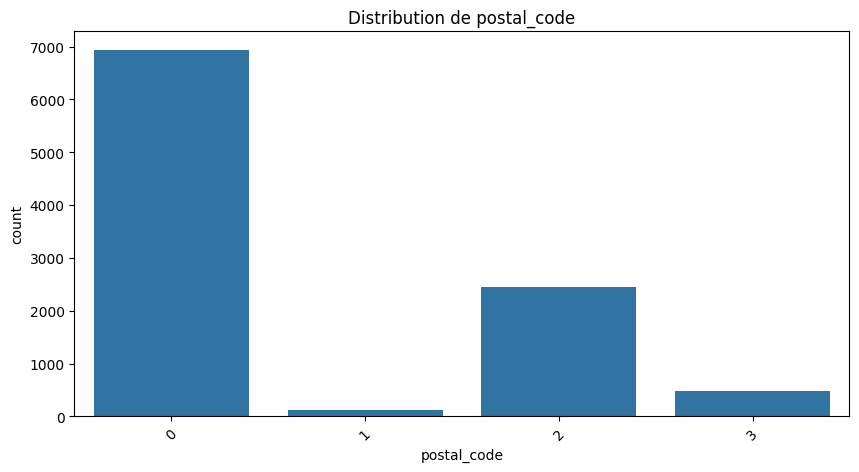

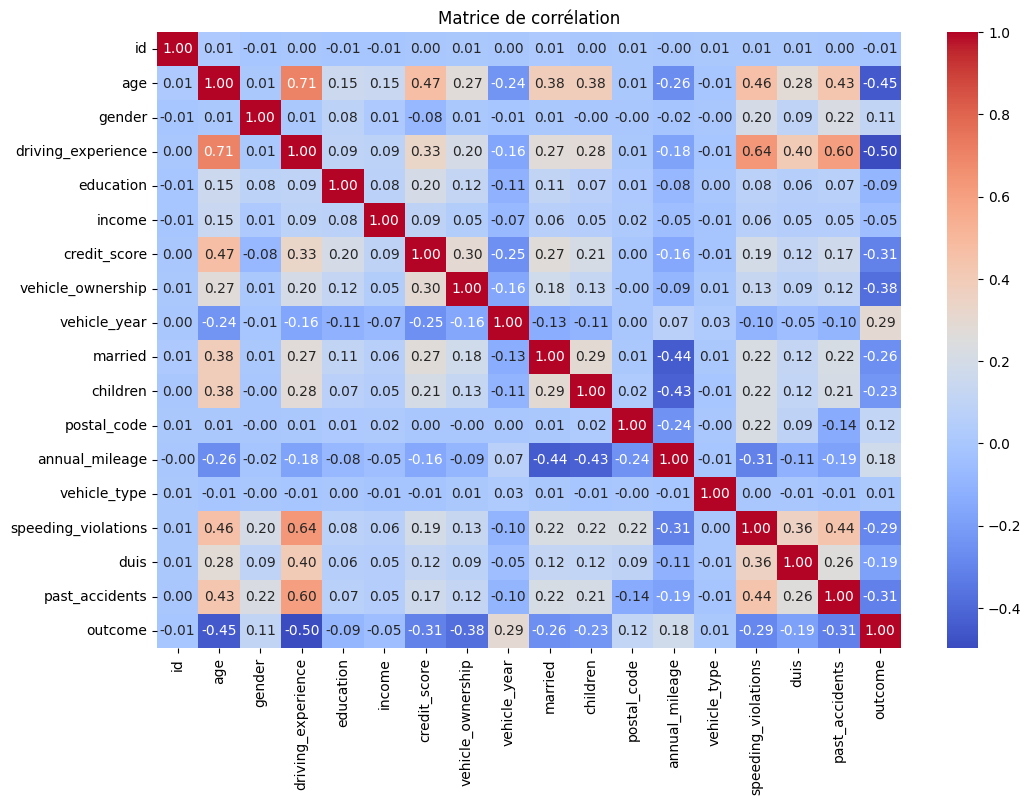

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from statsmodels.formula.api import logit
import matplotlib.pyplot as plt
import seaborn as sns


# Statistiques descriptives
print(cars.describe())

# Histogrammes pour les variables numériques
num_vars = ['credit_score', 'annual_mileage']
for var in num_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(cars[var], kde=True)
    plt.title(f'Distribution de {var}')
    plt.show()

# Boxplots pour les variables numériques
for var in num_vars:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=cars[var])
    plt.title(f'Boxplot de {var}')
    plt.show()

# Diagrammes à barres pour les variables catégorielles
for var in categorical_vars:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=cars[var])
    plt.title(f'Distribution de {var}')
    plt.xticks(rotation=45)
    plt.show()

# Heatmap de corrélation entre les variables
plt.figure(figsize=(12, 8))
sns.heatmap(cars.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()


**Interpretation**


Cette matrice de corrélation fournit des insights sur les relations entre divers attributs d'un dataset de données de conduite automobile. Par exemple, l'âge a une forte corrélation positive (0.71) avec l'expérience de conduite, ce qui est attendu puisque plus une personne est âgée, plus elle est susceptible d'avoir de l'expérience de conduite. D'un autre côté, l'âge présente également une corrélation négative significative (-0.448) avec l'outcome, suggérant que les conducteurs plus jeunes pourraient avoir des résultats moins favorables, possiblement en raison de moindre expérience ou prudence au volant.

## 4.Séléction des variables

### a. SelectKBest

In [7]:
from sklearn.feature_selection import SelectKBest, f_classif

# Préparation des données
X = cars.drop('outcome', axis=1)
y = cars['outcome']

# Sélection des k meilleures caractéristiques
selector = SelectKBest(score_func=f_classif, k=5)  # Sélectionner 5 meilleures caractéristiques
X_new = selector.fit_transform(X, y)

# Afficher les caractéristiques sélectionnées
selected_features = X.columns[selector.get_support(indices=True)]
print("SelectKBest selected features:", selected_features)


SelectKBest selected features: Index(['age', 'driving_experience', 'credit_score', 'vehicle_ownership',
       'past_accidents'],
      dtype='object')


**Interpretation**


Les meilleures caractéristiques sélectionnées par la méthode SelectKBest pour la modélisation sont l'âge, l'expérience de conduite, le score de crédit, la possession de véhicule et les accidents passés. Ces variables ont été identifiées comme ayant le plus grand impact ou la plus forte association avec la variable cible dans l'analyse.

### b. RFECV

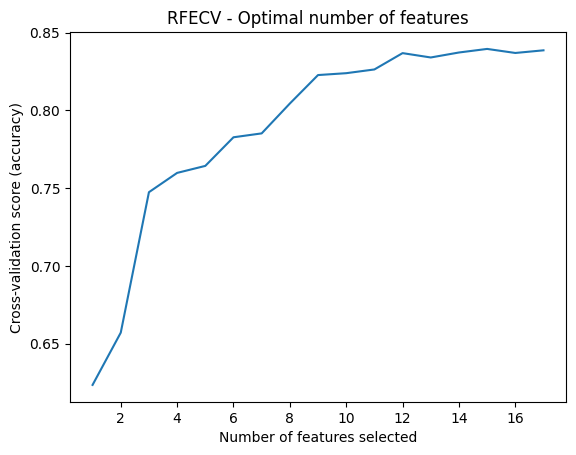

In [8]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier()
rfecv = RFECV(estimator, step=1, cv=5)
rfecv.fit(X, y)

plt.figure()
plt.title("RFECV - Optimal number of features")
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()



## 5) Tuning des modèles
### a. Régression Logistique (RL)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Définir la grille de paramètres
param_grid_lr = {
    'C': [0.1, 1, 10],  # Inverse de la force de régularisation
    'penalty': ['l2'],  # L1 entraîne des erreurs sous certaines versions de scikit-learn
    'solver': ['lbfgs', 'sag', 'saga']  # Solvers différents
}

# Initialiser le modèle de Régression Logistique
logreg = LogisticRegression(max_iter=10000)

# GridSearchCV
grid_lr = GridSearchCV(logreg, param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X, y)

# Meilleurs paramètres et score
print("Meilleurs paramètres pour RL:", grid_lr.best_params_)
print("Meilleur score pour RL:", grid_lr.best_score_)


Meilleurs paramètres pour RL: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Meilleur score pour RL: 0.7307


**Interpretation**


Les meilleurs paramètres trouvés pour le modèle de régression logistique (RL) incluent un paramètre de régularisation $C$ de $0.1$ , une pénalité $L2$ , et l'utilisation de l'algorithme 'lbfgs' pour l'optimisation. Le modèle atteint une performance optimale avec un score de précision de $0.7307$ sur les données de validation.

### b. Arbre de décision

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Définir la grille de paramètres
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Initialiser l'Arbre de décision
decision_tree = DecisionTreeClassifier()

# GridSearchCV
grid_dt = GridSearchCV(decision_tree, param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X, y)

# Meilleurs paramètres et score
print("Meilleurs paramètres pour l'Arbre:", grid_dt.best_params_)
print("Meilleur score pour l'Arbre:", grid_dt.best_score_)


Meilleurs paramètres pour l'Arbre: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}
Meilleur score pour l'Arbre: 0.8301999999999999


**Interpretation**

Pour le modèle d'arbre de décision, les meilleurs paramètres identifiés sont une profondeur maximale de $10$ , un minimum de $10$ échantillons par feuille, et un minimum de $2$ échantillons pour diviser un nœud. Ce modèle optimisé a atteint un score élevé de $0.8302$ , indiquant une performance robuste sur l'ensemble de données de test.

### c. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Définir la grille de paramètres
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Nombre d'arbres
    'max_depth': [None, 10, 20, 30],  # Profondeur maximale
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Initialiser le Random Forest
random_forest = RandomForestClassifier()

# GridSearchCV
grid_rf = GridSearchCV(random_forest, param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X, y)

# Meilleurs paramètres et score
print("Meilleurs paramètres pour RF:", grid_rf.best_params_)
print("Meilleur score pour RF:", grid_rf.best_score_)


Meilleurs paramètres pour RF: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 50}
Meilleur score pour RF: 0.8483


**Interpretation**


Les meilleurs paramètres déterminés pour le modèle de forêt aléatoire (Random Forest, RF) comprennent une profondeur maximale de 30, un minimum d'un échantillon par feuille, 20 échantillons minimum pour diviser un nœud, et 50 estimateurs. Ce modèle a obtenu un excellent score de 0.8483, reflétant une performance supérieure sur l'ensemble de données testé.


**Conclusion:**

En conclusion, les analyses de modèles prédictifs variés, y compris la régression logistique, l'arbre de décision, et la forêt aléatoire, ont révélé que le modèle de forêt aléatoire offre la meilleure performance avec un score de 0.8483, surpassant les autres modèles. Cela suggère que le modèle de forêt aléatoire est particulièrement efficace pour ce jeu de données, grâce à sa capacité à gérer la complexité et à capturer les interactions entre les variables. Chaque modèle a été optimisé avec des paramètres spécifiques qui maximisent leur efficacité, démontrant l'importance d'une sélection rigoureuse des paramètres dans le développement de modèles prédictifs robustes.






